# Preamble {-}


## Ocean Station Papa {-}

This lab is largely based on the following paper (which you only have to look at if you're interested):

Cronin, Meghan F., et al. "Estimating diffusivity from the mixed layer heat and salt balances in the North Pacific." Journal of Geophysical Research: Oceans 120.11 (2015): 7346-7362.

The data is from "Ocean Station Papa", which is a buoy in the North Pacific, south of Alasaka. Ocean Station Papa has been regularly survyed and measured since the early 50s, and has provided the data for many ocean and climate studies and papers. Ocean Station Papa is interesting because its a region where the ocean has a net heat uptake, but where the heat flux is largely driven by the atmosphere. This constrasts with the conditions in the western Pacific, where the Kurishio current plays an important part in the heat exchange. 

<img src="PapaQflux.png">


## Mixed layer budgets with varying heat capacicty {-}

In class we talked about a heat budget for the mixed layer which was something like 

$$ C \frac{dTs}{dt} = Q + \nabla \cdot \vec{F_O} $$

This works well if the depth of the mixed layer isn't changing. If the depth of the mixed layer is changing, then we need to include that in the time derivative, e.g.

$$ \frac{d(CTs)}{dt} = Q + \nabla \cdot \vec{F_O} $$

Lastly, we'll apprpixmate the convergence of heat flux by a single number which is assumed to represent the flux of heat from the mixed layer into the deep ocean, so that we will get:

$$ \frac{dTs}{dt} = \frac{dC}{dt}(Ts-Tb)\mathcal{\frac{dC}{dt}} + Q + D $$

where $Tb$ is the temperature of water just below the mixed layer. You can think of this term as the energy required to make the temperature of the water below the mixed layer match the temperature of the mixed layer.

To simplify things, we will assume that $Tb=280 K$ and $D=-29.5 W/m^2$ unless specified differently. This is a pretty big approximation, but the model is still decently realistic.

## Data {-}

Inside the folder BuoyDataSubset there are a bunch of files that give the hourly ouptuts from the buoy anchored at Ocean Station Papa. However, these data are very annoying to work with. To try and simplify things I have created 2 datasets, one with a representative year (2014), and one with a mean annual cycle that I calculated by averaging all of 2008 to 2014 together.

## Model {-}

There are a number of simple functions below that apply bulk formulas and timestep the previous equations. By combining these functions with the input data you can create a simple model of the surface temperatures at ocean station papa. A simple example of this is shown below.

# Hints {-}

- To generate a cosine or sine timeseries you can use numpy with something like: ``` np.cos(2*np.pi*np.linspace(0,1,Ny)) ``` where Ny is how many points in the time series that you want.

- if you only want to see the last part of an array, you can do something like ``` x[-500:] ``` to get the last 500 entries in x (as an example).

- to load the data properly you will have to set the indir formula at the start of the next cell.

- to find the number of nans in an array, you can use ``` np.isnan() ``` to get the total number. This is useful to see how much data is missing from a variable.

- the % symbol in python returns the modulus (or remainder after division) of a number, e.g. 14%4=2. This can be useful to set the inputs from a repeating dataset (as shown below).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd

# some input datasets that will get used 
indir = '../data/BuoyDataSubset'
ds = xr.open_dataset(f'{indir}/stationPapaAnnualCycle.nc')
ds23 = xr.open_dataset(f'{indir}/stationPapa2023.nc')
ds

<xarray.Dataset>
Dimensions:  (time: 8760)
Coordinates:
  * time     (time) datetime64[ns] 2001-01-01 ... 2001-12-31T23:00:00
Data variables:
    tas      (time) float32 ...
    ts       (time) float32 ...
    qa       (time) float32 ...
    rsds     (time) float32 ...
    rlts     (time) float32 ...
    sfcWind  (time) float32 ...
    qnet     (time) float32 ...
Attributes:
    info:     Data from Ocean Station Papa. Year is averaged over 2008-2014, ...

In [2]:
# some constants and routines for caculating the SSTs of the mixed layer model

Cp=1003. # specific heat capacity of air
Lv=2.5e6 # latent heating of vaporation
alpha=0.07 # fractional saturation rate
qs0=0.012 # reference specific humidity
Ch=1.5e-3 # heat transfer coeffecient
rho0=1.25 # reference density of air 
Cw = 4.2e3# specific heat capacity of water 
rhow = 1e3 # reference density of water 
sb = 5.67e-8 # stefan boltzman constant

# some bulk formulas
def compute_SH(Ts,Ta,W):
    '''
    Computes the sensible heat flux using a bulk formula. 
    Assumes constant Cp, rho, and Ch
    
    inputs:
    W - 10m wind speed
    Ts - surface temperature
    Ta - 2m air temperature
    '''
    return Cp*rho0*Ch*W*(Ts-Ta)

def compute_LH(Ts,qa,W):
    '''
    Computes the latent heat flux using a bulk formula. 
    Assumes constant alpha, Lv, rho, and Ch

    
    inputs:
    W - 10m wind speed
    Ts - surface temperature
    Ta - 2m air temperature
    '''
    
    # surface saturation
    qs = qs0 * np.exp(alpha*(Ts-290))

    return Lv*rho0*Ch*W*(qs-qa)

def compute_netQ(Ts,Ta,qa,LWD,SW,W):
    '''
    Computes the net energy tendency at the surface

    inputs 
    Ts: SST
    Ta: T at 2m 
    qa: specific humidity (kg/kg)
    LWD: longwave down 
    SW: net shortwave at the surface 
    W: Windspeed 

    output 
    Qn: net heating tendency in the mixed layer 
    '''

    # upwards longwave
    LWU = sb*Ts**4

    # latent flux 
    LH = compute_LH(Ts,qa,W)

    # sensible 
    SH = compute_SH(Ts,Ta,W)

    Qn =  SW + LWD - LWU -LH -SH

    return Qn

def stepTs(Ts, C, dCdt, Qn, Tsub, dt=3600, D=-29.5):
    '''
    Uses the Euler method to take 1 timestep of a mixed layer model, including entrainment 

    inputs
    Ts: surface temperature at previous time step
    C: curret heat capacity
    dCdt: change in heat capacity
    Qn: net surface energy flux 
    Tsub: temperature of water below the mixed layer 

    parameters
    dt: timestep, assumed to be 1 hour to match inputs
    D: net ocean heat uptake (default 29.5 W/m^2)

    outputs:
    Tsn: surface temperature at the new time step

    '''
    Tsn = Ts + dt/C *(Qn - dCdt*(Ts-Tsub) + D)
    return Tsn


Text(0.5, 0, 'time (years)')

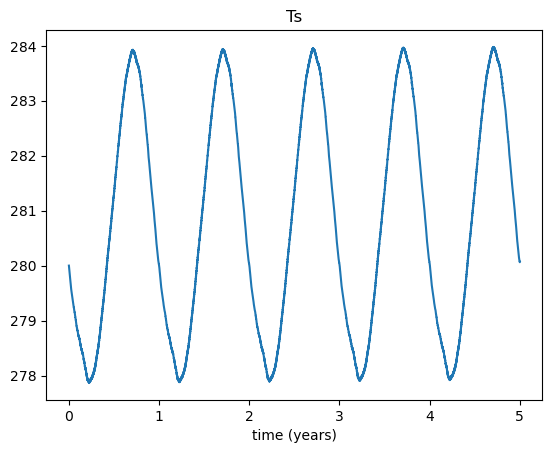

In [3]:
# simple mixed layer model with constant heat capacity and Qnet from observations

# set up the model 

C = 50*rhow*Cw
Ny = 24*365
N = Ny*5

Ts = np.zeros(N)
Ts[0]=280
Tsub=280

# run the model
for i in range(1,N):
    Qn = ds.qnet.data[i%Ny]
    Ts[i] = stepTs(Ts[i-1],C,0, Qn, Tsub )

# make a little plot
time=np.linspace(0,N*3600,N)

plt.plot(time/(24*3600*365),Ts)
plt.title('Ts')
plt.xlabel('time (years)')

# Problems start here 

# Questions {-}

## 1. Calculating fluxes and using this as input to the model. {-}

## 1.1 {-}
- Calculate the upwwards and downwards long wave, latent heat flux, and sensible heat flux for both 2023 and the annual cycle data. What are the main differences that you notice between the fluxes from both? What do you think explains the differences?

## 1.2 {-}
- Assuming a constant mixed layer depth of 50m, use the claculated fluxes from the annual cycle data to run the model for 5 years. Make a plot of the last year of data, and compare it to the surface temperatures from the annual cycle dataset.

## 2. The effects of varying mixed layer heat capacity on surface temperatures {-}

### 2.1 {-}

- Rerun the model with mixed layers between 30 and 80m, using the claculated fluxes from the annual cycle data to run the model for 5 years. What do you notice is the difference in the annual sea surface temperature cylce?

### 2.2 {-}

- Rerun the model but varying the mixed layer depth over the course of year with a cosine, with minnimum and maximum mixed layer depth between 30 and 70 m. How does this compare to the previous experiment?

## 3. Using the model to understand changes  {-}

For this problem, use the variable mixed layer model.

### 3.1 {-}

- Rerun the model but taking the annual mean of the (a) temperature and moisture data, and (b) radiation data, as inputs. Compare these runs to the run with the annual cycle present. Compare the effects of taking the mean of the temperature and moisture data compare to taking the mean of the radiation data.   

### 3.2 {-}
 
- Compare the effects of (a) raising the annual mean air temperature by 5K, (b) raising the annual mean downwards longwave by 25 W/m^2.